# Distilling Student Dropout Rules with Surrogate Trees

#### Trustworthy AI Examples Series

This notebook demonstrates how ensemble models can yield high accuracy but remain inscrutable to educational stakeholders. Using the Students dataset, this example scenario simulates a retention pipeline that predicts dropout risk based on academic performance and socioeconomic indicators. Model explainability is then performed, targeting rule extraction by training a shallow decision‐tree surrogate, ultimately converting complex forest decisions into actionable “if-then” rules for advisors.

Universities and student-support services need not only effective risk-prediction but also clear, simple criteria they can communicate to at-risk students. A surrogate decision tree distills the Random Forest’s intelligence into intuitive pathways and empowers advisors to tailor interventions based on a handful of critical rules.

Through this scenario, readers will:

1. **Understand intervention imperatives**: why opaque dropout predictions hinder timely academic support.
2. **Craft interpretable surrogates**: train a depth-3 decision tree on Random Forest outputs to extract clear decision rules.
3. **Drive student success**: translate extracted rules into targeted advising actions.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, f1_score

import python.utils.preprocessing as pp  

## Data Preparation

In order to train a model on the Students dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [3]:
train_data = pp.load_data(PROJECT_ROOT / 'data/students_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/students_test.csv')
df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Target'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 3539 samples
Test set size: 885 samples
Number of features: 168


## Random Forest Classifier Model

### Model Training

The model used in this scenario is an `RandomForestClassifier` from the scikit-learn library, configured with:

- **`n_estimators=100`**: the number of boosting rounds.

This ensemble method is well-suited for tabular educational data, as it handles both numerical and categorical features effectively and is robust to overfitting due to its averaging mechanism.

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation

After training, the model is evaluated on the test set using two key metrics:

- Accuracy (79.4%): — the proportion of correct predictions.
- F1 Score (0.778): — the harmonic mean of precision and recall, which balances false positives and false negatives.

An accuracy of 79.4% suggests the model is correctly identifying most dropout cases, while an F1 score of 0.778 indicates a balanced performance across classes. These results show that the model captures meaningful patterns in the data, though some variability remains unexplained. This opens opportunities to enrich the feature set or explore more complex architectures.

In [5]:
rf_preds = rf_model.predict(X_test)

acc = accuracy_score(y_test, rf_preds)
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.794
F1 Score: 0.778


## Surrogate Decision Tree

### Model Training

To improve interpretability, a surrogate model is trained to mimic the Random Forest’s predictions. This surrogate is a shallow decision tree with a maximum depth of 3, offering a simplified view of the ensemble’s decision logic.

In [6]:
rf_train_preds = rf_model.predict(X_train)

surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, rf_train_preds)

DecisionTreeClassifier(max_depth=3, random_state=42)

### Model Visualization

The surrogate tree is visualized to reveal its decision structure. Each node represents a split on a feature, and each leaf corresponds to a predicted class. This approach enables stakeholders like academic advisors to understand and act on model outputs without needing to interpret hundreds of trees.

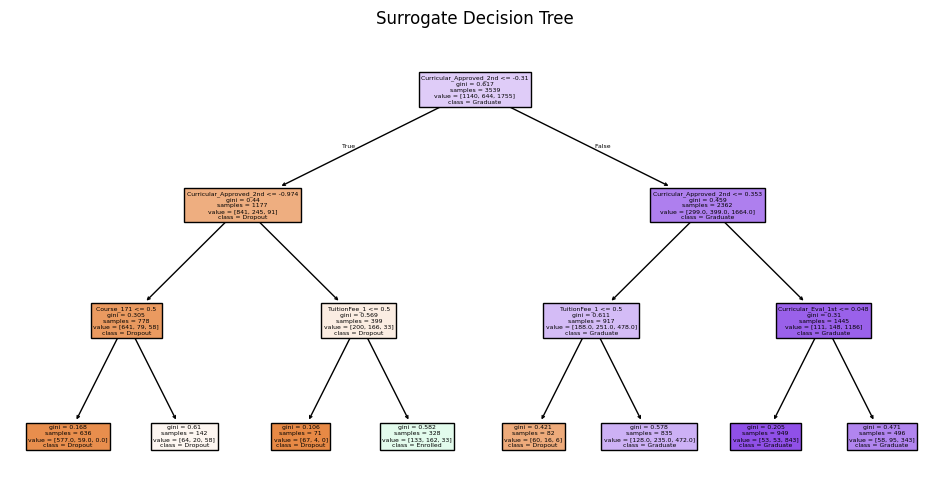

In [9]:
plt.figure(figsize=(12, 6))
plot_tree(surrogate, feature_names=X_train.columns, class_names=[str(cls) for cls in surrogate.classes_], filled=True)
plt.title("Surrogate Decision Tree")
plt.show()

## Extract Decision Rules

The surrogate’s logic is extracted as a set of human-readable rules. These rules translate complex model behavior into actionable “if-then” statements. These rules highlight key academic indicators, such as second-semester approvals and tuition payment status, that strongly influence dropout risk. Ideally, this provides the foundation for outreach that advisors can leverage to identify and support struggling students.

In [10]:
rules = export_text(surrogate, feature_names=list(X_train.columns))

print("Extracted Rules:\n")
print(rules)

Extracted Rules:

|--- Curricular_Approved_2nd <= -0.31
|   |--- Curricular_Approved_2nd <= -0.97
|   |   |--- Course_171 <= 0.50
|   |   |   |--- class: Dropout
|   |   |--- Course_171 >  0.50
|   |   |   |--- class: Dropout
|   |--- Curricular_Approved_2nd >  -0.97
|   |   |--- TuitionFee_1 <= 0.50
|   |   |   |--- class: Dropout
|   |   |--- TuitionFee_1 >  0.50
|   |   |   |--- class: Enrolled
|--- Curricular_Approved_2nd >  -0.31
|   |--- Curricular_Approved_2nd <= 0.35
|   |   |--- TuitionFee_1 <= 0.50
|   |   |   |--- class: Dropout
|   |   |--- TuitionFee_1 >  0.50
|   |   |   |--- class: Graduate
|   |--- Curricular_Approved_2nd >  0.35
|   |   |--- Curricular_Eval_1st <= 0.05
|   |   |   |--- class: Graduate
|   |   |--- Curricular_Eval_1st >  0.05
|   |   |   |--- class: Graduate



## Surrogate Fidelity Evaluation

To assess how well the surrogate approximates the original model, its predictions are compared to those of the Random Forest. The fidelity score reflects the agreement between the two.

A fidelity score of 86.4% indicates that the surrogate captures most of the Random Forest’s logic, validating its use as an interpretable proxy.

In [11]:
surrogate_preds = surrogate.predict(X_test)
fidelity = accuracy_score(rf_preds, surrogate_preds)

print(f"Surrogate Fidelity (Agreement with RF): {fidelity:.3f}")

Surrogate Fidelity (Agreement with RF): 0.864


## Takeaways

This scenario illustrates a common tension in educational data science: the trade-off between predictive performance and interpretability. The Random Forest model achieved solid performance, with an accuracy of 79.4% and an F1 score of 0.778, indicating that it effectively captures patterns associated with student dropout. However, as with many ensemble methods, its internal logic is difficult to interpret, making its insights difficult to act on.

To bridge this gap, a surrogate decision tree was trained to approximate the Random Forest’s behavior. With a maximum depth of 3, the surrogate distilled the complex ensemble into a small set of transparent, rule-based decisions.

The surrogate achieved a high fidelity score, meaning it closely mirrored the Random Forest’s decisions while remaining interpretable. By translating model outputs into clear, actionable rules, institutions can better identify at-risk students and tailor interventions that are both data-driven and transparent, fostering a more equitable and supportive academic environment.